In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
import numpy as np
from tensorflow.keras.datasets import mnist

# Load and prepare the MNIST data
(input_train, label_train), (input_test, label_test) = mnist.load_data()
input_train, input_test = input_train / 255.0, input_test / 255.0  # Normalize to [0, 1]

# Resize to fit model input (28, 28, 1) for grayscale images
input_train = np.expand_dims(input_train, -1)
input_test = np.expand_dims(input_test, -1)

# Function to create pairs of images and labels (1 for similar, 0 for dissimilar)
def create_pairs(images, labels, num_pairs=10000):
    pairs = []
    pair_labels = []
    num_classes = 10
    digit_indices = [np.where(labels == i)[0] for i in range(num_classes)]

    for _ in range(num_pairs):
        # Select a random digit
        digit = np.random.randint(0, num_classes)
        idx1, idx2 = np.random.choice(digit_indices[digit], 2, replace=False)
        # Add a similar pair
        pairs += [[images[idx1], images[idx2]]]
        pair_labels += [1]

        # Add a dissimilar pair
        other_digit = (digit + np.random.randint(1, num_classes)) % num_classes
        idx1, idx2 = np.random.choice(digit_indices[digit], 1), np.random.choice(digit_indices[other_digit], 1)
        pairs += [[images[idx1][0], images[idx2][0]]]
        pair_labels += [0]

    return np.array(pairs), np.array(pair_labels)

# Generate training and testing pairs
train_pairs, train_labels = create_pairs(input_train, label_train, num_pairs=60000)
test_pairs, test_labels = create_pairs(input_test, label_test, num_pairs=10000)

# Channel Attention Module (CAM)
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_layer_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal')
    shared_layer_two = layers.Dense(channel, kernel_initializer='he_normal')

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)
    return layers.Multiply()([input_feature, cbam_feature])

# Spatial Attention Module (SAM)
def spatial_attention(input_feature):
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_feature)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    cbam_feature = layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal')(concat)
    return layers.Multiply()([input_feature, cbam_feature])

# CBAM Block (Combines CAM and SAM)
def cbam_block(input_feature, ratio=8):
    x = channel_attention(input_feature, ratio)
    x = spatial_attention(x)
    return x

# Define the CNN model with CBAM attention for MNIST
def create_cnn_with_attention(input_shape=(28, 28, 1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    return models.Model(inputs, x)

# Define Euclidean distance function
def euclidean_distance(vectors):
    featsA, featsB = vectors
    sum_squared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Define Siamese model with CBAM CNN base
def create_siamese_network(input_shape=(28, 28, 1)):
    inputA = layers.Input(shape=input_shape)
    inputB = layers.Input(shape=input_shape)

    base_cnn = create_cnn_with_attention(input_shape)
    featsA = base_cnn(inputA)
    featsB = base_cnn(inputB)

    distance = layers.Lambda(euclidean_distance)([featsA, featsB])
    output = layers.Dense(1, activation="sigmoid")(distance)

    return models.Model(inputs=[inputA, inputB], outputs=output)

# Compile and train the model
siamese_model = create_siamese_network()
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
siamese_model.fit(
    [train_pairs[:, 0], train_pairs[:, 1]], train_labels,
    validation_data=([test_pairs[:, 0], test_pairs[:, 1]], test_labels),
    batch_size=32,
    epochs=2
)

# Test prediction on a test pair
test_pred = siamese_model.predict([test_pairs[0:1, 0], test_pairs[0:1, 1]])
print("Similarity score:", test_pred[0][0])


In [5]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
import numpy as np

# Load and prepare the MNIST data
(input_train, label_train), (input_test, label_test) = mnist.load_data()
input_train, input_test = input_train / 255.0, input_test / 255.0  # Normalize to [0, 1]

# Resize to fit model input (28, 28, 1) for grayscale images
input_train = np.expand_dims(input_train, -1)
input_test = np.expand_dims(input_test, -1)

# Channel Attention Module (CAM)
def channel_attention(input_feature, ratio=8):
    channel = input_feature.shape[-1]
    shared_layer_one = layers.Dense(channel // ratio, activation='relu', kernel_initializer='he_normal')
    shared_layer_two = layers.Dense(channel, kernel_initializer='he_normal')

    avg_pool = layers.GlobalAveragePooling2D()(input_feature)
    avg_pool = layers.Reshape((1, 1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)

    max_pool = layers.GlobalMaxPooling2D()(input_feature)
    max_pool = layers.Reshape((1, 1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)

    cbam_feature = layers.Add()([avg_pool, max_pool])
    cbam_feature = layers.Activation('sigmoid')(cbam_feature)
    return layers.Multiply()([input_feature, cbam_feature])

# Spatial Attention Module (SAM)
def spatial_attention(input_feature):
    avg_pool = layers.Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_feature)
    max_pool = layers.Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_feature)
    concat = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    cbam_feature = layers.Conv2D(filters=1, kernel_size=7, strides=1, padding='same', activation='sigmoid', kernel_initializer='he_normal')(concat)
    return layers.Multiply()([input_feature, cbam_feature])

# CBAM Block (Combines CAM and SAM)
def cbam_block(input_feature, ratio=8):
    x = channel_attention(input_feature, ratio)
    x = spatial_attention(x)
    return x

# Define the CNN model with CBAM attention for MNIST classification
def create_cnn_with_attention(input_shape=(28, 28, 1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = cbam_block(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dense(10, activation='softmax')(x)  # 10 classes for MNIST
    return models.Model(inputs, x)

# Create and compile the model
model = create_cnn_with_attention()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(input_train, label_train, validation_data=(input_test, label_test), batch_size=32, epochs=2)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(input_test, label_test)
print(f"Test Accuracy: {test_accuracy}")


Epoch 1/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 146s 76ms/step - accuracy: 0.8874 - loss: 0.3835 - val_accuracy: 0.9836 - val_loss: 0.0502
Epoch 2/2
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 140s 74ms/step - accuracy: 0.9859 - loss: 0.0467 - val_accuracy: 0.9879 - val_loss: 0.0387
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.9858 - loss: 0.0442
Test Accuracy: 0.9879000186920166


In [ ]:
(input_train, label_train), (input_test, label_test) = mnist.load_data()
input_train, input_test = input_train / 255.0, input_test / 255.0
input_train.shape

In [ ]:
from tensorflow.keras.utils import plot_model

# Assuming 'model' is already created
plot_model(model, to_file='model_flowchart.png', show_shapes=True, show_layer_names=True)


In [7]:
pip install netron


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.5 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [8]:
# Save the model to a .h5 file
model.save("/kaggle/working/model.h5")

# Open the model in Netron
import netron
netron.start("/kaggle/working/model.h5")


Serving '/kaggle/working/model.h5' at http://localhost:8080


('localhost', 8080)

In [9]:
pip install visualkeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.7/993.7 kB 23.3 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


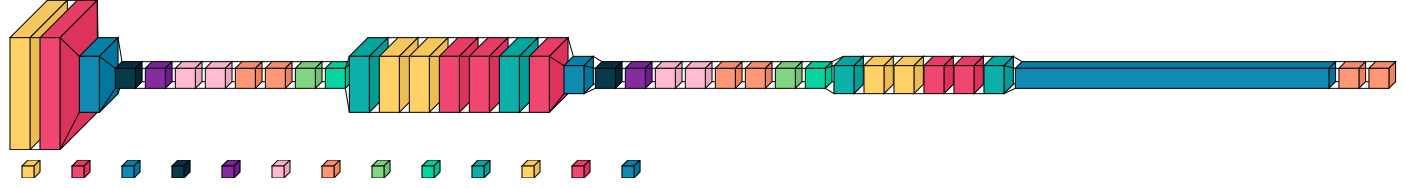

In [11]:
import visualkeras

# Generate a visualization of the model
visualkeras.layered_view(model, legend=True, draw_volume=True)  # Set options as needed


In [12]:
pip install networkit


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.7/13.7 MB 13.6 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [17]:
plot_model(
    model,
    to_file='model.png',
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=200,
    show_layer_activations=True,
    show_trainable=True)